# ResNet transfer learning for Digit Recognizer

## Setup

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

## Data

In [30]:
train = pd.read_csv('train.csv')
print(train.shape)

(42000, 785)


## Preprocessing

In [31]:
y = train['label'].values

# normalize it by dividing by 255
X = train.drop('label', axis = 1).values.reshape((-1, 28, 28, 1)) / 255

# since ResNet is for 3 channel color image but digit is grayscale 1 channle, change it to 3 channel below
X = np.concatenate((X, X, X), axis = 3)

print(X.shape)

(42000, 28, 28, 3)


In [32]:
# We need below to work categorical_crossentropy loss in compiling
y_binary = to_categorical(y)
print(y_binary.shape)
print(y_binary[:6, :])

(42000, 10)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Model

In [33]:
num_classes = 10

model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet'))
model.add(Dense(num_classes, activation = 'softmax'))

# specified not to change pre-trained weights
model.layers[0].trainable = False

In [34]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [35]:
history = model.fit(X,
                    y_binary,
                    batch_size = 100,
                    epochs = 10,
                    verbose = 1,
                    validation_split = 0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 228s 7ms/sample - loss: 1.0001 - acc: 0.6971 - val_loss: 14.0313 - val_acc: 0.0889
Epoch 2/10
33600/33600 [==============================] - 232s 7ms/sample - loss: 0.6184 - acc: 0.8092 - val_loss: 11.2693 - val_acc: 0.0808
Epoch 3/10
33600/33600 [==============================] - 232s 7ms/sample - loss: 0.5462 - acc: 0.8294 - val_loss: 1.9231 - val_acc: 0.4820
Epoch 4/10
33600/33600 [==============================] - 232s 7ms/sample - loss: 0.5119 - acc: 0.8404 - val_loss: 1.1331 - val_acc: 0.6832
Epoch 5/10
33600/33600 [==============================] - 232s 7ms/sample - loss: 0.4831 - acc: 0.8454 - val_loss: 0.6013 - val_acc: 0.8265
Epoch 6/10
33600/33600 [==============================] - 233s 7ms/sample - loss: 0.4832 - acc: 0.8480 - val_loss: 0.5847 - val_acc: 0.8344
Epoch 7/10
33600/33600 [==============================] - 233s 7ms/sample - loss: 0.4720 - acc: 0.8501 - val_

In [36]:
# function to monitor model performance in each epoch
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'], label = 'Training accuracy')
    plt.plot(hist['epoch'], hist['val_acc'], label = 'Validation accuracy')
    plt.legend()
    plt.show()

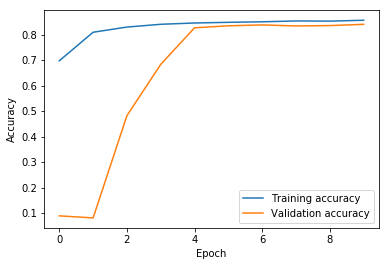

In [37]:
plot_history(history)

## Test data prediction

In [38]:
test = pd.read_csv("test.csv")
print(test.shape)
print(test.head())

(28000, 784)
   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0

In [39]:
X_test = test.values.reshape((-1, 28, 28, 1)) / 255
X_test = np.concatenate((X_test, X_test, X_test), axis = 3)
print(X_test.shape)

(28000, 28, 28, 3)


In [40]:
pred_test = model.predict(X_test)
print(pred_test.shape)
print(pred_test[0])
print(np.argmax(pred_test[0]))

(28000, 10)
[1.98022067e-03 6.80077983e-06 8.20579171e-01 5.22922054e-02
 8.54235329e-03 4.31741495e-03 1.13346602e-03 1.06894195e-01
 3.51111143e-04 3.90305649e-03]
2


## Submission

In [43]:
test_id = np.arange(1, test.shape[0] + 1, 1)
predictions = np.argmax(pred_test, axis = 1)

sub = pd.DataFrame(data = {'ImageId': test_id,
                           'Label': predictions})
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,4
3,4,9
4,5,3


In [49]:
sub.to_csv('C:\\Users\\yukic\\Documents\\kaggle\\digit_recognizer\\submission_190911.csv', index = False)